In [109]:
import pandas as pd
from io import StringIO
from sklearn.metrics import f1_score


# Read data from the CSV file and select only the required columns.
filename = 'smartbugs/results_aggregated_src.csv'

if 'src' in filename:
    out_csv = 'reentrancy_metrics_data_src.csv'
    latex_file = 'latex_table_src.csv'
    aggregated_file = 'aggregated_results_src.csv'
    input
else:
    out_csv = 'reentrancy_metrics_data_bins.csv'
    latex_file = 'latex_table_bins.csv'
    aggregated_file = 'aggregated_results_bins.csv'
df = pd.read_csv(filename)
df = df[['filename', 'basename', 'exit_code', 'toolid', 'findings']]
# print(df)
df['exit_code'] = df['exit_code'].fillna(-1).astype(int)
#print(df.shape)

if 'src' in filename:
    df = df[df['filename'].str.contains('safe|ree', na=False)]
# print(df)
#print(df.shape)
# A dictionary mapping each tool to the string(s) it produces for a reentrancy finding.
# You can easily update this dictionary as needed. For tools with multiple labels,
# use a comma-separated string, e.g., 'tool_name': 'label1,label2'.
reentrancy_labels = {
    'ccc': 'Reentrancy_Vulnerability',
    'confuzzius': 'Reentrancy',
    'conkas': 'Reentrancy', #.sol 0.5
    #'manticore-0.3.7': 'Reentrancy', # placeholder
    'mythril-0.24.7': 'State_access_after_external_call_SWC_107',
    'oyente+-2acaf2e': 'Re_Entrancy_Vulnerability',
    'securify': 'DAO_', 
    'securify2': 'Reentrancy', # does not work
    'sfuzz': 'Reentrancy', 
    'slither-0.11.3': 'reentrancy_eth,reentrancy_no_eth',
    #'smartcheck': 'Reentrancy', # never finds any occurrence of reentrancy
    'solhint-6.0.0': 'reentrancy',
    #'ethainter': 'Reentrancy', # does not work
    'ethor-2023': 'insecure',
    'oyente+-060ca34':'Re_Entrancy_Vulnerability',
    'vandal': 'ReentrantCall',
    'gpt-oss': 'reentrant',
    'gpt-5-mini': 'reentrant',
    'gpt-5': 'reentrant',
    'gpt-5-nano': 'reentrant'
    }

# 1. Determine the "true" reentrancy label for each file based on its filename.
# 'ree' followed by an optional number indicates a true reentrancy vulnerability.
df['true_reentrancy'] = df['filename'].str.contains(r'ree', case=False)
# df['true_reentrancy'] = df['basename'].str.contains(r'_ree', case=False)
# if df['true_reentrancy'].isnull().any():
#     df['true_reentrancy'] = df['filename'].str.contains(r'_ree', case=False)
# print(df)

# 2. Determine the "predicted" reentrancy label based on the 'findings' column.
# This function will check if any of the tool-specific reentrancy labels are present in the findings.
def get_prediction(row):
    tool_id = row['toolid']
    findings = str(row['findings']) # Convert to string to handle potential NaN values

    # Check if the tool is in our labels dictionary.
    if tool_id in reentrancy_labels:
        # Split the tool's finding string into a list of individual labels.
        tool_findings = [f.strip() for f in reentrancy_labels[tool_id].split(',')]
        
        # Check if any of the tool's labels are present in the findings from the data.
        for label in tool_findings:
            if label in findings:
                return True
    return False

df['predicted_reentrancy'] = df.apply(get_prediction, axis=1)
#print(df['exit_code']==1)




# 3. Calculate metrics for each unique tool and print only the results.
# Analyze only the tools present in the reentrancy_labels dictionary.
tools_to_analyze = reentrancy_labels.keys()
good_tools = []
print("Reentrancy Metrics per Tool:")
print("=" * 30)

print('Tool, Accuracy, Precision, Recall, F1 Score, Errors')
for tool in tools_to_analyze:

    # Filter the DataFrame for the current tool.
    tool_df = df[df['toolid'] == tool]

    n_results = tool_df.shape[0]

    ERRORS = (tool_df['exit_code'] != 0).sum()

    ERRORS2  = tool_df[(tool_df['exit_code'] != 0) & (tool_df['findings'] == '{}')].shape[0]/n_results if n_results >0 else 0
    # Exclude rows where exit_code is not
    # print(tool_df.shape)
    

    #tool_df = tool_df[(tool_df['exit_code'] == '0') | ((tool_df['exit_code'] != 0) & tool_df['findings']!= '{}')]
    
    #print( tool_df['findings'], tool_df['findings']!= '{}')
    #tool_df = tool_df[tool_df['exit_code'] == '0']
    # if tool == 'vandal':
    #     print(tool_df, tool_df.shape)

    # Calculate True Positives (TP), False Positives (FP), True Negatives (TN), and False Negatives (FN).
    TP = len(tool_df[(tool_df['true_reentrancy'] == True) & (tool_df['predicted_reentrancy'] == True)])
    FP = len(tool_df[(tool_df['true_reentrancy'] == False) & (tool_df['predicted_reentrancy'] == True)])
    TN = len(tool_df[(tool_df['true_reentrancy'] == False) & (tool_df['predicted_reentrancy'] == False)])
    FN = len(tool_df[(tool_df['true_reentrancy'] == True) & (tool_df['predicted_reentrancy'] == False)])
    # print(TP, FP, TN, FN)
    
    # Calculate Accuracy, Precision, and Recall.
    # Handle cases where the denominator is zero to avoid errors.
    accuracy = (TP + TN) / (TP + FP + TN + FN) if (TP + FP + TN + FN) > 0 else 0
    
    # Precision: Out of all positive predictions, how many were correct?
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    
    # Recall: Out of all actual positives, how many were correctly predicted?
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0

    # Calculate the F1 Score
    f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    f1_score = 2 * TP / (2 * TP + FP + FN) if (2 * TP + FP + FN) > 0 else 0
    #f1_score = f1_score(tool_df['true_reentrancy'], tool_df['predicted_reentrancy'], zero_division=0, average = 'weighted')
    if f1_score > 0:
        good_tools.append(tool)
        print(f"{tool}, {accuracy*100:.2f}, {precision*100:.2f}, {recall*100:.2f}, {f1_score*100:.2f}, {ERRORS2*100:.2f}" )
        # print(f"  Accuracy:  {accuracy*100:.2f}")
        # print(f"  Precision: {precision*100:.2f}")
        # print(f"  Recall:    {recall*100:.2f}")
        # print(f"  F1 Score:  {f1_score*100:.2f}")
        # #print(f"  Errors: {ERRORS}")
        # print(f"  Errors: {ERRORS2*100:.2f}")
        # print("-" * 30)

print(df.shape)
df = df[(df['exit_code'] == 0) | ((df['exit_code'] != 0) & (df['findings'] != '{}'))]
print(df.shape)
# Save the DataFrame to a new CSV file.
filtered_df = df[df['toolid'].isin(good_tools)]
filtered_df.to_csv(out_csv, index=False)
print(f"\nSaved CSV with only tools that found something → {out_csv}")

Reentrancy Metrics per Tool:
Tool, Accuracy, Precision, Recall, F1 Score, Errors
ccc, 88.66, 90.80, 65.83, 76.33, 25.46
confuzzius, 88.43, 94.87, 61.67, 74.75, 15.97
conkas, 83.73, 67.42, 78.07, 72.36, 18.18
mythril-0.24.7, 85.56, 83.78, 47.69, 60.78, 7.22
securify, 87.50, 100.00, 47.73, 64.62, 25.54
sfuzz, 76.16, 70.73, 24.17, 36.02, 45.14
slither-0.11.3, 95.14, 88.37, 95.00, 91.57, 0.00
solhint-6.0.0, 81.02, 89.58, 35.83, 51.19, 0.69
oyente+-060ca34, 91.20, 91.84, 75.00, 82.57, 0.00
(5199, 7)
(3941, 7)

Saved CSV with only tools that found something → reentrancy_metrics_data_src.csv


In [110]:
filtered_df

,filename,basename,exit_code,toolid,findings,true_reentrancy,predicted_reentrancy
0,mytests/aggregated-benchmark/src/safe/01dd4a2e...,01dd4a2eacf1f751bcf9070bca20c3a2_cgt.sol,0,ccc,{Reentrancy_Vulnerability},False,True
1,mytests/aggregated-benchmark/src/safe/04045504...,04045504816e9b4137a6838c8a53dde4_cgt.sol,0,ccc,{},False,False
2,mytests/aggregated-benchmark/src/safe/083e6035...,083e60356eeecf6edf0e82b79f66a4ba_cgt.sol,0,ccc,{A_miner_can_use_others_input_to_gain_a_benefi...,False,False
3,mytests/aggregated-benchmark/src/safe/0a7dcd7a...,0a7dcd7ad58d91e0373b21e4e4522cdf_cgt.sol,0,ccc,{Result_of_expression_can_be_over_or_under_flo...,False,False
4,mytests/aggregated-benchmark/src/safe/0bf0ebe3...,0bf0ebe31b1e67618bc28a9d3738a2e4.sol,0,ccc,{Missing_Check_of_Return_Value_from_external_C...,False,False
...,...,...,...,...,...,...,...
5194,mytests/aggregated-benchmark/src/safe/f21a8244...,f21a824407dfb37c81f7fbbd8d8e0e58_cgt.sol,1,solhint-6.0.0,"{avoid_call_value,avoid_low_level_calls,avoid_...",False,False
5195,mytests/aggregated-benchmark/src/reentrant/f26...,f26ed098ddfa730dd9cebaaaab1bceac_cgt.sol,1,solhint-6.0.0,"{avoid_call_value,avoid_low_level_calls,compil...",True,False
5196,mytests/aggregated-benchmark/src/safe/f40afd3f...,f40afd3fefac7bcb1b05c424d48579a7_cgt.sol,1,solhint-6.0.0,"{avoid_throw,compiler_version,const_name_snake...",False,False
5197,mytests/aggregated-benchmark/src/reentrant/f73...,f73768e16680cd9fffd24f529e8a6083_cgt.sol,1,solhint-6.0.0,"{avoid_call_value,avoid_low_level_calls,compil...",True,True


In [111]:
import pandas as pd

# Load data
df_loc = pd.read_csv("contracts_loc.csv")
df_re = pd.read_csv(out_csv)

# Normalize strings
df_loc["contract_name"] = df_loc["contract_name"].str.strip()
df_re["basename"] = df_re["basename"].str.strip()

# Create a lookup dictionary: {contract_name: loc}
loc_map = dict(zip(df_loc["contract_name"], df_loc["loc"]))

# Add the LOC column based on basename
df_re["loc"] = df_re["basename"].map(loc_map)

# Show rows that did NOT find a match
missing = df_re[df_re["loc"].isna()]["basename"].unique()
print(f"Contracts with NO LOC match: {len(missing)}")
for m in missing:
    print(" -", m)

df_re


Contracts with NO LOC match: 0


,filename,basename,exit_code,toolid,findings,true_reentrancy,predicted_reentrancy,loc
0,mytests/aggregated-benchmark/src/safe/01dd4a2e...,01dd4a2eacf1f751bcf9070bca20c3a2_cgt.sol,0,ccc,{Reentrancy_Vulnerability},False,True,153
1,mytests/aggregated-benchmark/src/safe/04045504...,04045504816e9b4137a6838c8a53dde4_cgt.sol,0,ccc,{},False,False,28
2,mytests/aggregated-benchmark/src/safe/083e6035...,083e60356eeecf6edf0e82b79f66a4ba_cgt.sol,0,ccc,{A_miner_can_use_others_input_to_gain_a_benefi...,False,False,155
3,mytests/aggregated-benchmark/src/safe/0a7dcd7a...,0a7dcd7ad58d91e0373b21e4e4522cdf_cgt.sol,0,ccc,{Result_of_expression_can_be_over_or_under_flo...,False,False,15
4,mytests/aggregated-benchmark/src/safe/0bf0ebe3...,0bf0ebe31b1e67618bc28a9d3738a2e4.sol,0,ccc,{Missing_Check_of_Return_Value_from_external_C...,False,False,18
...,...,...,...,...,...,...,...,...
2946,mytests/aggregated-benchmark/src/safe/f21a8244...,f21a824407dfb37c81f7fbbd8d8e0e58_cgt.sol,1,solhint-6.0.0,"{avoid_call_value,avoid_low_level_calls,avoid_...",False,False,364
2947,mytests/aggregated-benchmark/src/reentrant/f26...,f26ed098ddfa730dd9cebaaaab1bceac_cgt.sol,1,solhint-6.0.0,"{avoid_call_value,avoid_low_level_calls,compil...",True,False,24
2948,mytests/aggregated-benchmark/src/safe/f40afd3f...,f40afd3fefac7bcb1b05c424d48579a7_cgt.sol,1,solhint-6.0.0,"{avoid_throw,compiler_version,const_name_snake...",False,False,98
2949,mytests/aggregated-benchmark/src/reentrant/f73...,f73768e16680cd9fffd24f529e8a6083_cgt.sol,1,solhint-6.0.0,"{avoid_call_value,avoid_low_level_calls,compil...",True,True,342


In [112]:
# 1. seleziono solo i contratti davvero reentrant
df_true = df_re[df_re["true_reentrancy"] == True]

# 2. per ogni contratto, verifico se almeno un tool lo ha beccato
grouped = df_true.groupby("basename")["predicted_reentrancy"].any()

# 3. contratti reentranti NON rilevati da nessun tool
undetected = grouped[grouped == False].index.tolist()

print("Reentrant contracts NOT detected by any tool:", len(undetected))
for u in undetected:
    print(" -", u)


Reentrant contracts NOT detected by any tool: 0


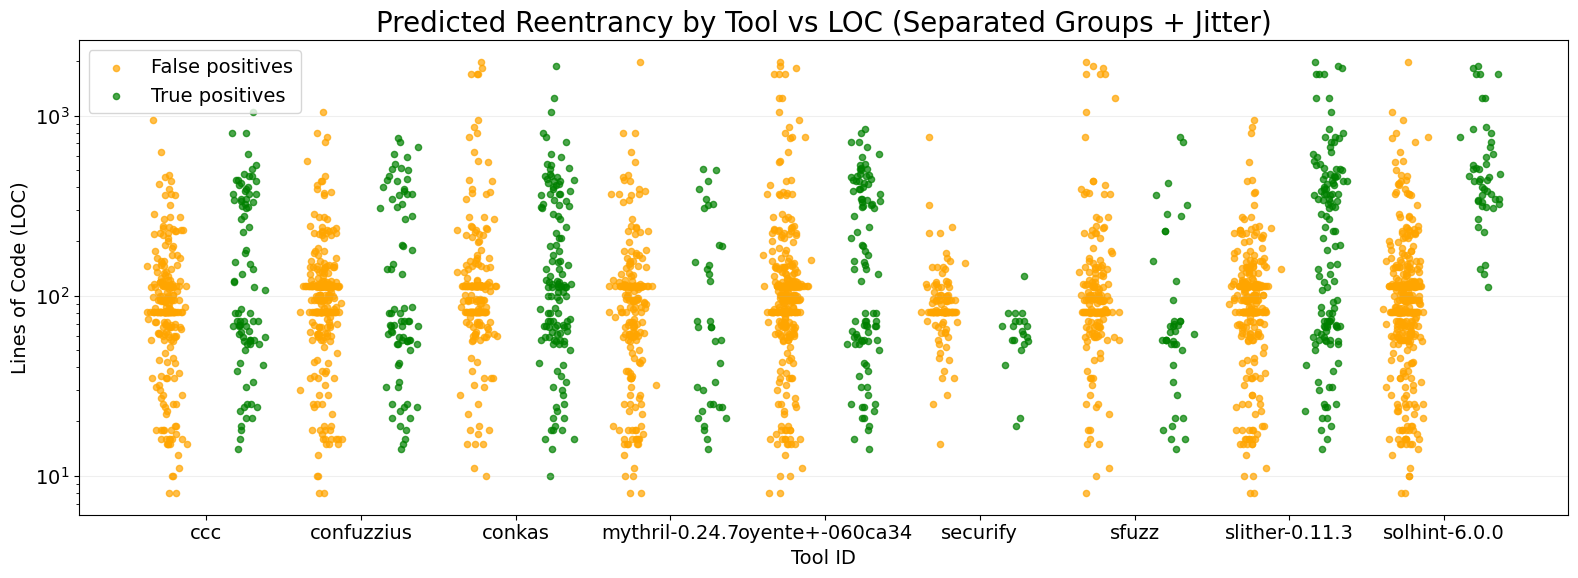

In [113]:
import matplotlib.pyplot as plt
import numpy as np

# df_re must contain: toolid, loc, predicted_reentrancy

plt.figure(figsize=(16, 6))

tools = sorted(df_re["toolid"].unique())

# For each tool we create two x positions:
# left cluster  = predicted False
# right cluster = predicted True
x_base = {tool: i for i, tool in enumerate(tools)}

# width of separation between the two groups per tool
offset = 0.25

for tool in tools:
    subset = df_re[df_re["toolid"] == tool]
    base = x_base[tool]

    # FALSE group (orange)
    false_group = subset[subset["predicted_reentrancy"] == False]
    x_false = np.full(len(false_group), base - offset)
    x_false_jitter = x_false + np.random.normal(0, 0.05, size=len(false_group))

    plt.scatter(
        x_false_jitter,
        false_group["loc"],
        c="orange",
        s=20,
        alpha=0.7,
        label="False positives" if tool == tools[0] else None
    )

    # TRUE group (green)
    true_group = subset[subset["predicted_reentrancy"] == True]
    x_true = np.full(len(true_group), base + offset)
    x_true_jitter = x_true + np.random.normal(0, 0.05, size=len(true_group))

    plt.scatter(
        x_true_jitter,
        true_group["loc"],
        c="green",
        s=20,
        alpha=0.7,
        label="True positives" if tool == tools[0] else None
    )

# X-axis tick labels centered between groups
plt.xticks(range(len(tools)), tools)
plt.yscale("log")

plt.xlabel("Tool ID")
plt.ylabel("Lines of Code (LOC)")
plt.title("Predicted Reentrancy by Tool vs LOC (Separated Groups + Jitter)")
plt.legend()
plt.grid(axis='y', alpha=0.2)

plt.tight_layout()
plt.show()


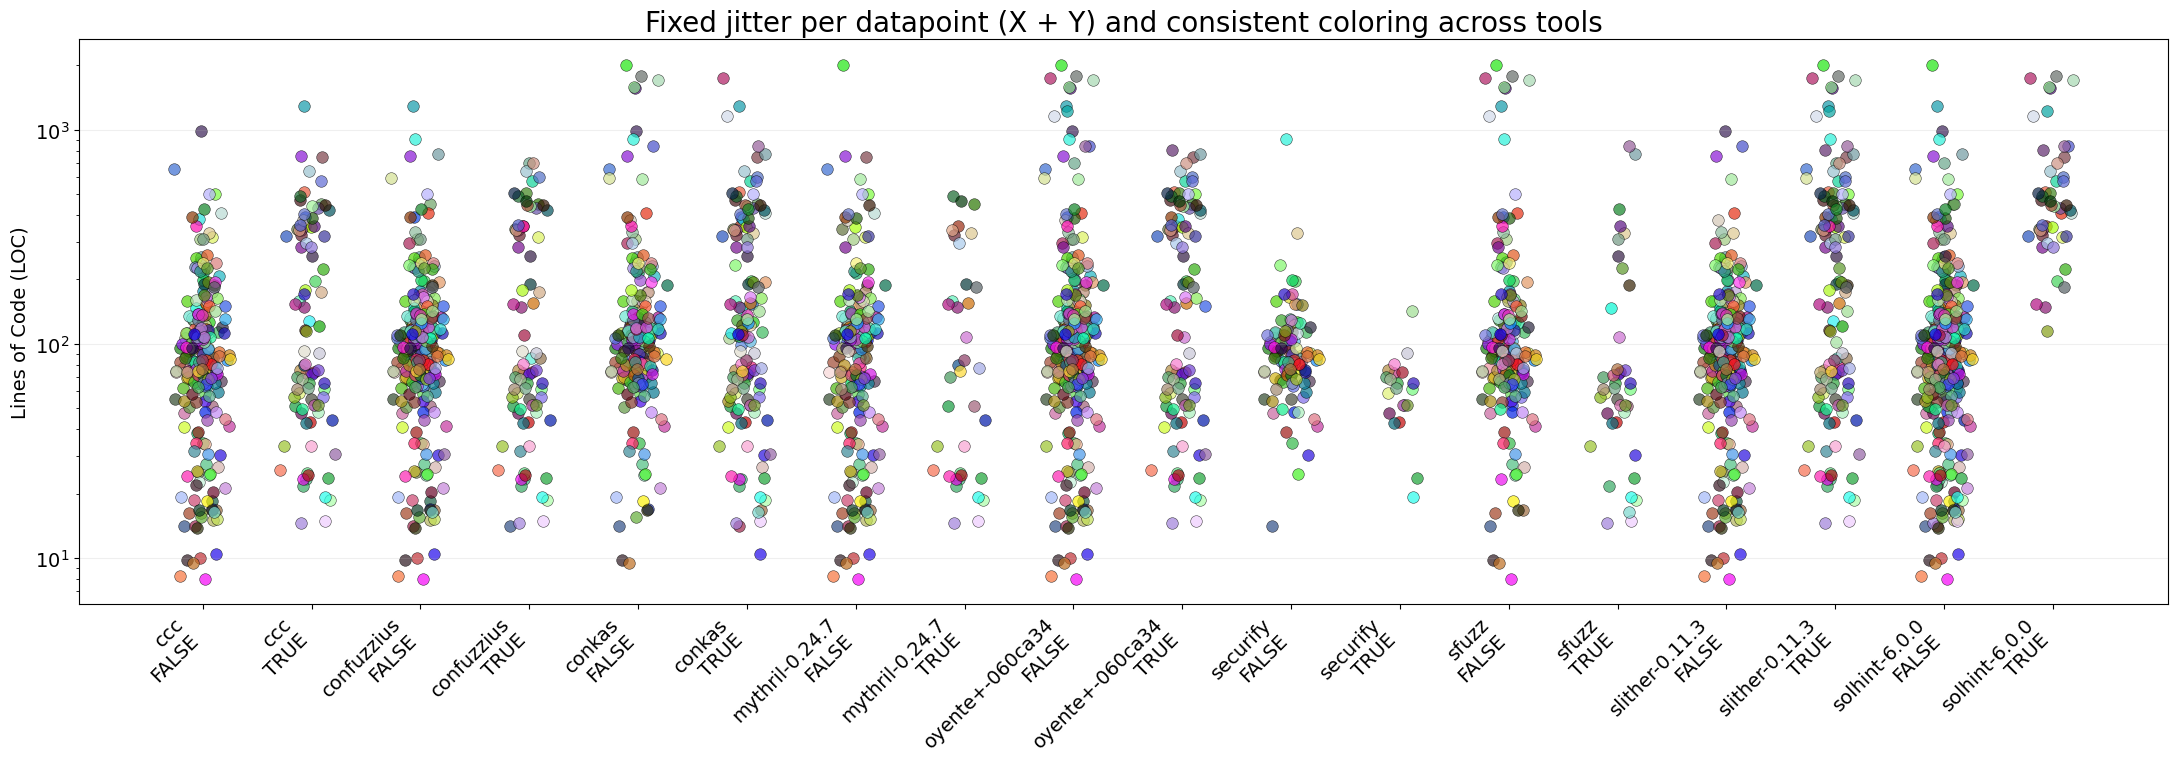

In [114]:
import matplotlib.pyplot as plt
import numpy as np

df = df_re.copy()

# ----------------------------------------------------
# 1. Assign UNIQUE COLOR + UNIQUE X-JITTER + UNIQUE Y-JITTER to each datapoint
# ----------------------------------------------------
unique_points = df["basename"].unique()
np.random.seed(42)

colors = {}
x_jitter = {}
y_jitter = {}

for name in unique_points:
    colors[name] = np.random.rand(3,)        # unique RGB color
    x_jitter[name] = np.random.normal(0, 0.1)  # FIXED X jitter
    y_jitter[name] = np.random.normal(0, 0.1)  # FIXED Y jitter

# ----------------------------------------------------
# 2. Build X-axis groups: tool_FALSE, tool_TRUE
# ----------------------------------------------------
tools = sorted(df["toolid"].unique())

x_labels = []
x_positions = {}
pos = 0

for tool in tools:
    x_positions[(tool, False)] = pos
    x_labels.append(f"{tool}\nFALSE")
    pos += 1
    
    x_positions[(tool, True)] = pos
    x_labels.append(f"{tool}\nTRUE")
    pos += 1

# ----------------------------------------------------
# 3. PLOT — fixed jitter X + fixed jitter Y
# ----------------------------------------------------
plt.figure(figsize=(22, 8))

for _, row in df.iterrows():
    name = row["basename"]
    tool = row["toolid"]
    loc = row["loc"]
    pred = row["predicted_reentrancy"]

    # FIXED jitter per datapoint
    x = x_positions[(tool, pred)] + x_jitter[name]
    y = loc * (1 + y_jitter[name])

    plt.scatter(
        x,
        y,
        c=[colors[name]],
        s=70,
        alpha=0.7,
        edgecolor="black",
        linewidth=0.4
    )

# ----------------------------------------------------
# 4. Formatting
# ----------------------------------------------------
plt.yscale("log")
plt.xticks(range(len(x_labels)), x_labels, rotation=45, ha='right')
plt.ylabel("Lines of Code (LOC)")
plt.title("Fixed jitter per datapoint (X + Y) and consistent coloring across tools")

plt.grid(axis='y', alpha=0.2)
plt.tight_layout()
plt.show()


C:\Users\ressi\AppData\Local\Temp\ipykernel_16704\3112976577.py:15: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pivot = pivot.fillna(False)
C:\Users\ressi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\upsetplot\plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the oper

KeyError: "None of ['predicted_reentrancy'] are in the columns"

<Figure size 1000x1500 with 0 Axes>

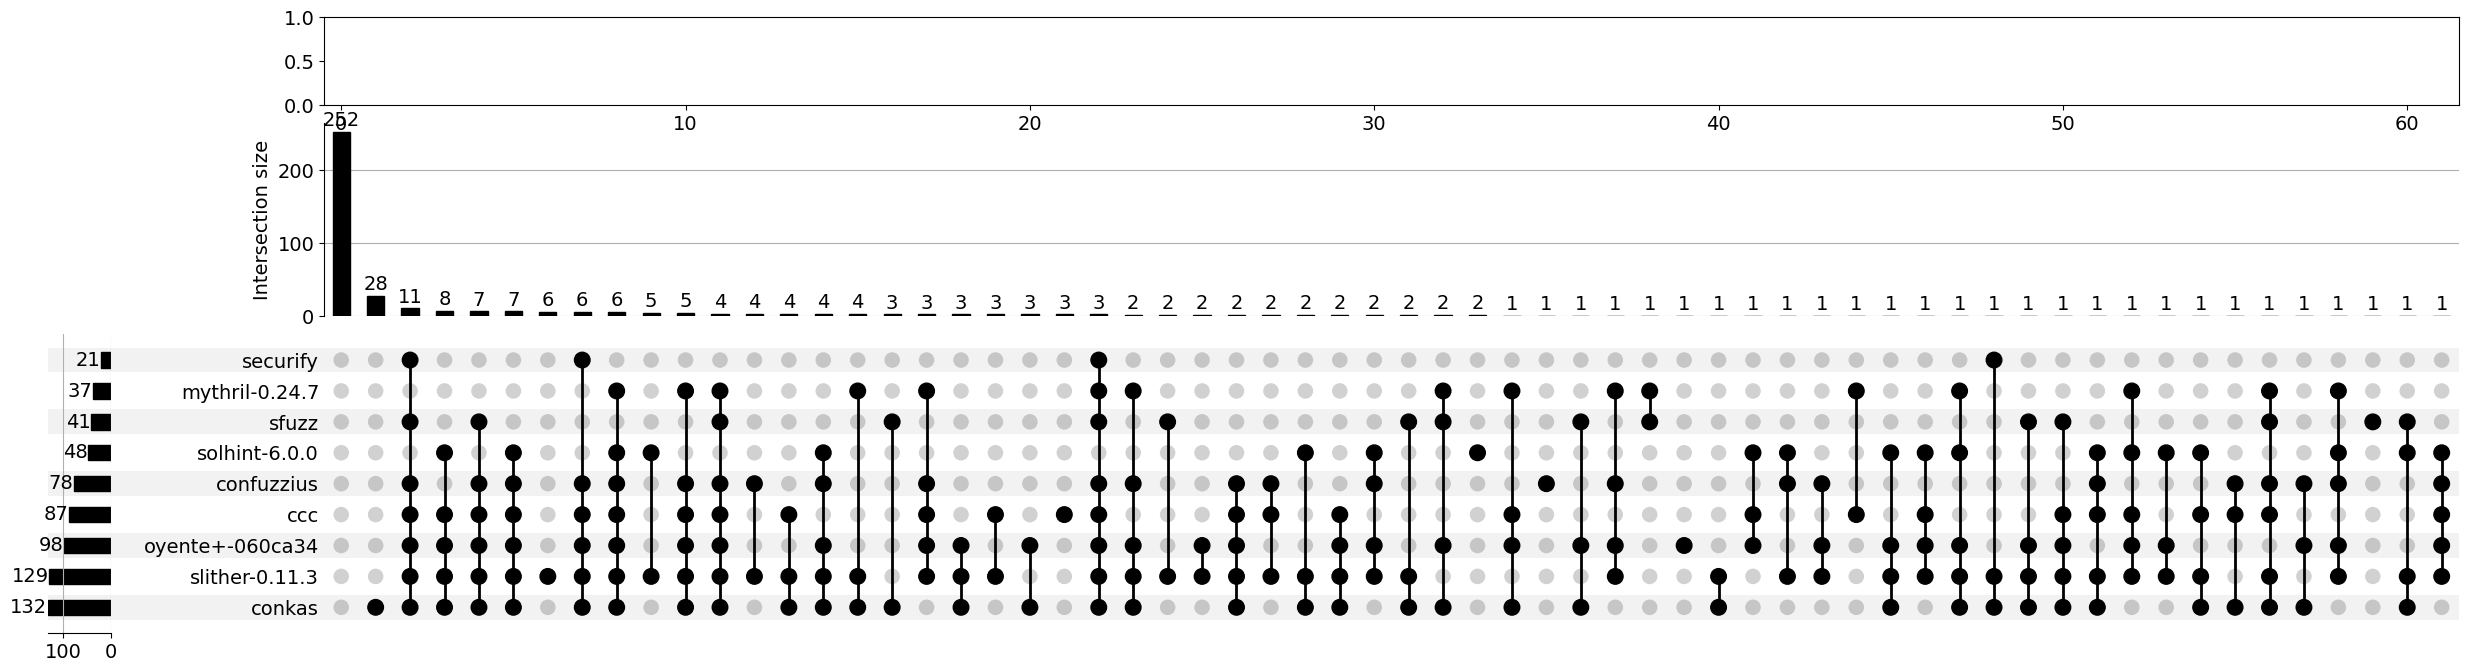

In [124]:

import matplotlib.pyplot as plt
from upsetplot import UpSet, from_indicators
from matplotlib import cm

# -------------------------------------------------------
# 1) Pivot booleano: righe = contratti, colonne = tool
# -------------------------------------------------------
pivot = df_re.pivot_table(
    index="basename",
    columns="toolid",
    values="predicted_reentrancy",
    aggfunc="first"
)

pivot = pivot.fillna(False)
pivot = pivot.astype(bool)

# -------------------------------------------------------
# 2) Convertiamo nel formato corretto per upsetplot
# -------------------------------------------------------
upset_data = from_indicators(pivot)

# -------------------------------------------------------
# 3) Plot finale
# -------------------------------------------------------

plt.rcParams.update({
    "font.size": 14,         # base font size
    "axes.titlesize": 20,    # title
    "axes.labelsize": 14,    # x/y labels
    "xtick.labelsize": 14,   # x ticks
    "ytick.labelsize": 14,   # y ticks
    "legend.fontsize": 14,   # legend
})

plt.figure(figsize=(10, 15))

u = UpSet(
    upset_data,
    subset_size="count",
    sort_by="cardinality",
    show_counts=True
)
u.add_stacked_bars(
    by="predicted_reentrancy", colors=cm.Pastel1, title="Count by predicted reentrancy")

u.plot()





plt.suptitle("True Positives Across Tools - Aggregated Benchmark")
plt.savefig("upset_plot.pdf", format="pdf", bbox_inches="tight")
plt.show()


C:\Users\ressi\AppData\Local\Temp\ipykernel_16704\2825983376.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ).fillna(False).astype(bool)
C:\Users\ressi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\upsetplot\data.py:303: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(False, inplace=True)
C:\Users\ressi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\upsetplot\plotting.py:795: FutureWarning

<Figure size 1400x1000 with 0 Axes>

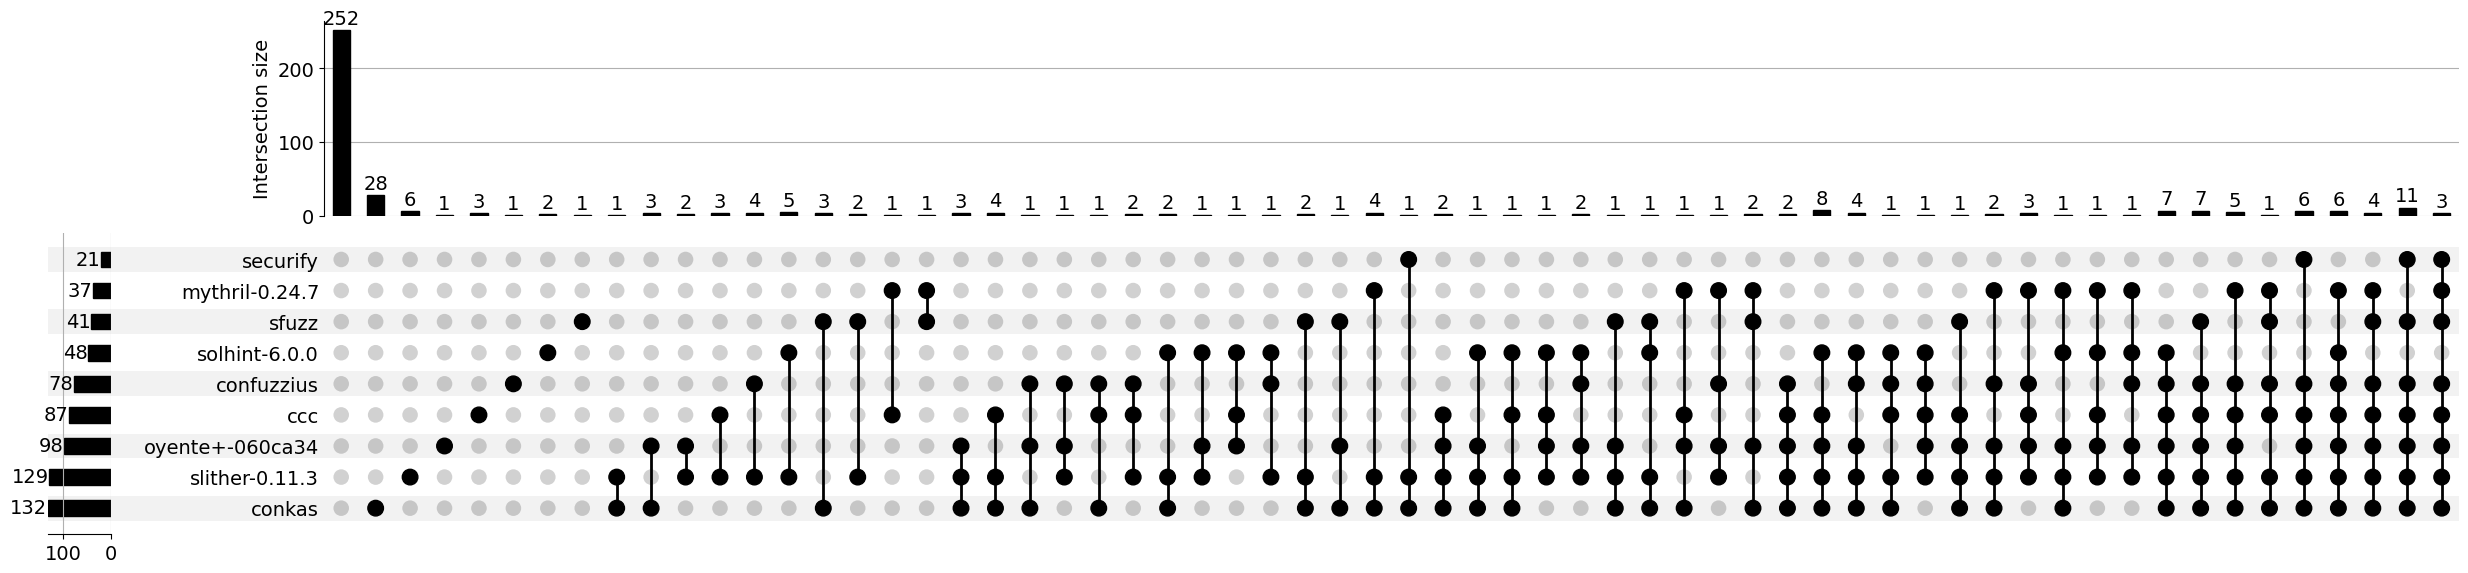

In [116]:
from upsetplot import UpSet, from_memberships

# pivot: righe = basename, colonne = toolid, valori=True/False
pivot = df_re.pivot_table(
    index="basename",
    columns="toolid",
    values="predicted_reentrancy",
    aggfunc="first"
).fillna(False).astype(bool)

memberships = []
for basename, row in pivot.iterrows():
    tools_true = [tool for tool, pred in row.items() if pred]
    memberships.append(tools_true)   # <<-- includes empty lists for undetected

data = from_memberships(memberships, data=list(pivot.index))

plt.figure(figsize=(14, 10))
UpSet(data, subset_size="count", show_counts=True).plot()
plt.show()



In [117]:
df_re

,filename,basename,exit_code,toolid,findings,true_reentrancy,predicted_reentrancy,loc
0,mytests/aggregated-benchmark/src/safe/01dd4a2e...,01dd4a2eacf1f751bcf9070bca20c3a2_cgt.sol,0,ccc,{Reentrancy_Vulnerability},False,True,153
1,mytests/aggregated-benchmark/src/safe/04045504...,04045504816e9b4137a6838c8a53dde4_cgt.sol,0,ccc,{},False,False,28
2,mytests/aggregated-benchmark/src/safe/083e6035...,083e60356eeecf6edf0e82b79f66a4ba_cgt.sol,0,ccc,{A_miner_can_use_others_input_to_gain_a_benefi...,False,False,155
3,mytests/aggregated-benchmark/src/safe/0a7dcd7a...,0a7dcd7ad58d91e0373b21e4e4522cdf_cgt.sol,0,ccc,{Result_of_expression_can_be_over_or_under_flo...,False,False,15
4,mytests/aggregated-benchmark/src/safe/0bf0ebe3...,0bf0ebe31b1e67618bc28a9d3738a2e4.sol,0,ccc,{Missing_Check_of_Return_Value_from_external_C...,False,False,18
...,...,...,...,...,...,...,...,...
2946,mytests/aggregated-benchmark/src/safe/f21a8244...,f21a824407dfb37c81f7fbbd8d8e0e58_cgt.sol,1,solhint-6.0.0,"{avoid_call_value,avoid_low_level_calls,avoid_...",False,False,364
2947,mytests/aggregated-benchmark/src/reentrant/f26...,f26ed098ddfa730dd9cebaaaab1bceac_cgt.sol,1,solhint-6.0.0,"{avoid_call_value,avoid_low_level_calls,compil...",True,False,24
2948,mytests/aggregated-benchmark/src/safe/f40afd3f...,f40afd3fefac7bcb1b05c424d48579a7_cgt.sol,1,solhint-6.0.0,"{avoid_throw,compiler_version,const_name_snake...",False,False,98
2949,mytests/aggregated-benchmark/src/reentrant/f73...,f73768e16680cd9fffd24f529e8a6083_cgt.sol,1,solhint-6.0.0,"{avoid_call_value,avoid_low_level_calls,compil...",True,True,342
